In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

df = pd.read_csv('../data/XAU_1d_signals_combo_all.csv', index_col='Date', parse_dates=True)

In [2]:
# --- 2. Επιλογή σημάτων -1 και 1 και προετοιμασία ---
df = df[df['Signal_Combo3'].isin([-1, 1])].copy()
df.dropna(inplace=True)

features = [
    'Close', 'Volume',
    'SMA_20', 'SMA_50', 'SMA_100', 'SMA_200',
    'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200',
    'RSI_14', 'MACD', 'MACD_Signal', 'ATR_14'
]
target = 'Signal_Combo3'

X = df[features]
y = df[target].replace({-1: 0, 1: 1})

In [3]:
# --- 3. Διαχωρισμός Train/Test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



In [4]:
# --- 4. Εκπαίδευση μοντέλων ---
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=pos_weight,
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train, y_train)


/Users/foivosampatzis/Documents/Project's/superstore_sales_analysis/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:43:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [5]:
# --- 5. Threshold Tuning ---
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
threshold = 0.6
y_pred_xgb = (y_proba_xgb >= threshold).astype(int)

In [6]:
# --- 6. Αξιολόγηση Μοντέλων ---
print("\n=== Random Forest ===")
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

print("\n=== XGBoost (Threshold {:.2f}) ===".format(threshold))
print(classification_report(y_test, y_pred_xgb))



=== Random Forest ===
              precision    recall  f1-score   support

           0       0.84      0.55      0.67       278
           1       0.85      0.96      0.90       761

    accuracy                           0.85      1039
   macro avg       0.85      0.76      0.79      1039
weighted avg       0.85      0.85      0.84      1039


=== XGBoost (Threshold 0.60) ===
              precision    recall  f1-score   support

           0       0.40      0.37      0.38       278
           1       0.78      0.80      0.79       761

    accuracy                           0.68      1039
   macro avg       0.59      0.58      0.59      1039
weighted avg       0.68      0.68      0.68      1039



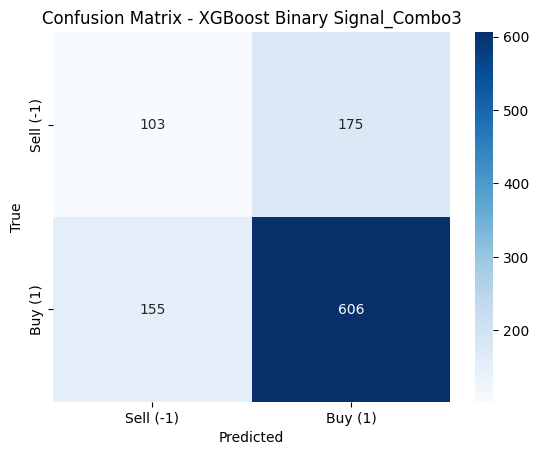

In [7]:
# --- 7. Confusion Matrix (XGBoost) ---
cm = confusion_matrix(y_test, y_pred_xgb, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Sell (-1)', 'Buy (1)'], yticklabels=['Sell (-1)', 'Buy (1)'], cmap='Blues')
plt.title('Confusion Matrix - XGBoost Binary Signal_Combo3')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


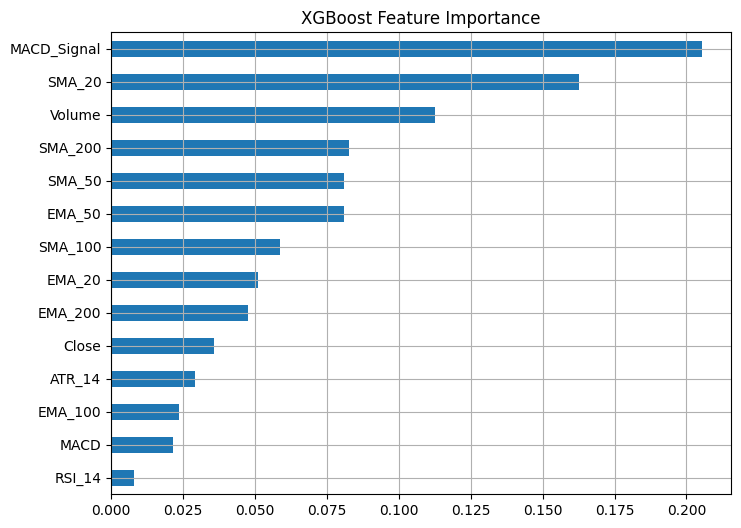

In [8]:
# --- 8. Σημαντικότητα χαρακτηριστικών (XGBoost) ---
importances = pd.Series(xgb_model.feature_importances_, index=features)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title('XGBoost Feature Importance')
plt.grid(True)
plt.show()
